# Machine-Learning-and-Statistics-Project 2020

***

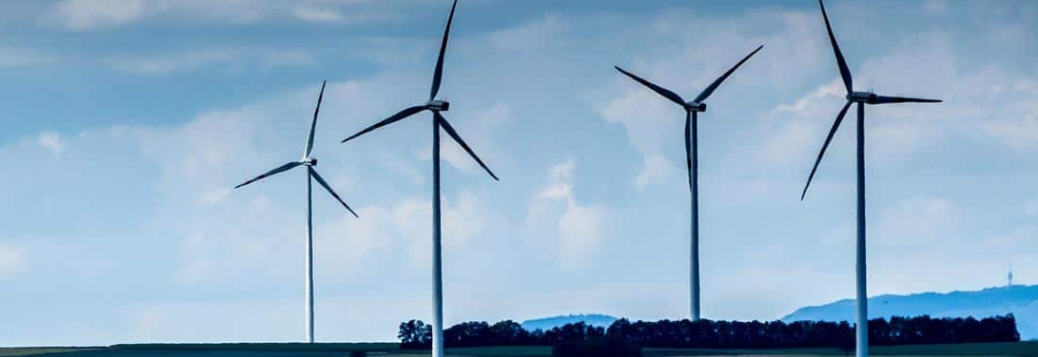

## Introduction

The goal of this project is to produce a model that accurately predicts wind turbine power output from wind speed values. A web service that responds with predicted power values based on speed values sent as HTTP requests is also included. 
This is based on the data set powerproduction. 

### Task objectives:
- Understand how wind turbines operate.
- Explore the Power production dataset.
- Explore models.
- Determine model to use.
- Develop web service.

### How do wind turbines operate?

The ESB provides detail on their website regarding the operation of wind turbines.  "They operate automatically, self-starting when the wind speed reaches an average of about three to five metres per second (about 10 mph), equal to that of a gentle breeze which otherwise would only be strong enough to rustle leaves and light twigs. The output increases linearly with the wind speed until the wind speed reaches 13 to 14 metres per second (about 30 mph) equal to that of a strong breeze. At this point, the wind turbine will reach its maximum generating capacity.

If the average wind exceeds the maximum operational limit of 25 meters per second, equal to that of a storm, the wind turbine shuts down by the feathering of blades, in order to avoid excessive wear-and-tear. Upon the average wind speed dropping back below 25 m/s the wind turbine will restart". [6]

## Explore the dataset

In [1]:
# Import libraries
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np

In [2]:
# Make matplotlib show interactive plots in the notebook.
%matplotlib inline

# Apply the default seaborn settings.
sns.set()

#Set plot style.
plt.style.use("ggplot")

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

In [3]:
# Import the power production dataset and call it pp
pp = pd.read_csv("powerprod.csv")

In [4]:
pp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,500.0,12.590398,7.224991,0.0,6.32475,12.5505,18.77525,25.000
power,500.0,48.014584,41.614572,0.0,5.28800,41.6455,93.53700,113.556


In [5]:
pp.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


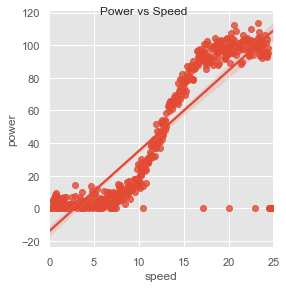

In [6]:
p = sns.pairplot(data=pp,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

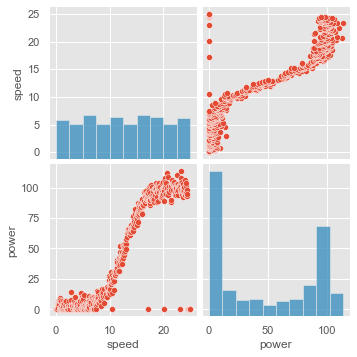

In [7]:
sns.pairplot(pp)

### Observations

The powerproduction dataset correlates with information provided by the ESB regarding the operation of turbines:

- Once speed hits 3 - 5 m/s, they start to operate.
- Output increases linearly until 25 m/s which is maximum capacity.
- Turbines shut down once the maximum limit has been reached.

From the charts above, a linear correlation is apparent once the turbine is fully operational (approx 10 - 25 m/s).<br>

### Should certain data points be excluded?
 
In his "Deep learning with Python" book, Francois Chollet [9] says that "In general, with neural networks, it’s safe to input missing values as 0, with the condition that 0 isn’t already a meaningful value. The network will learn from exposure to the data that the value 0 means missing data and will start ignoring the value."

Due to operational constraints of the turbines, I believe it makes sense to include only data points relating to the time when they are operational.  The max value is 25 m/s (per the summary table  above), so values below 3 need to be excluded (minimum start point). There are also a number of data points with zero power output.  These likely relate to downtime related to maintenance so these will also be excluded.  In summary the following will be excluded for model exploration:

- Speed below 3 m/s.
- Power output of zero.
This means that we are excluding 88 data points approximately 18% of the dataset. 

### Clean the Data

In [8]:
# Adapted from https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior
j = pp[(pp.speed < 3) | (pp.power == 0)]
j.count()

speed    88
power    88
dtype: int64

### Review the revised charts

In [9]:
# Adapted from https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior
# Exclude values less than 3 m/s & zero power output.
pp1 = pp[(pp.speed > 3) & (pp.power != 0)]
pp1

,speed,power
56,3.003,3.578
57,3.028,2.633
58,3.053,2.836
59,3.078,3.063
61,3.203,1.360
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


In [10]:
pp1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,412.0,14.102507,6.092924,3.003,8.85275,14.3515,19.17525,24.399
power,412.0,57.855840,39.359088,0.067,13.13475,68.4240,95.60025,113.556


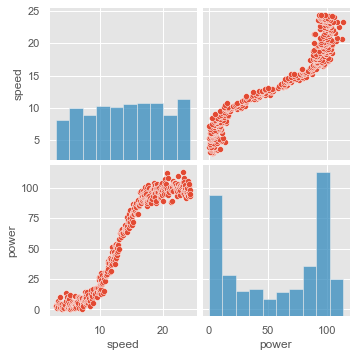

In [11]:
sns.pairplot(pp1)

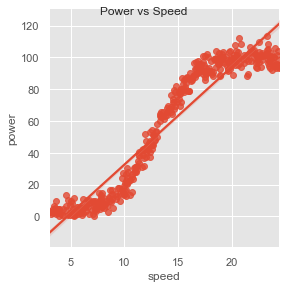

In [12]:
p = sns.pairplot(data=pp1,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

### Final oberservations of the revised data

The dataset appears to follow a uniform distribution.  The relationship does appear linear (possibly sigmoid).  The data is much cleaner allowing models can be explored on an even footing.

***

## Explore models
Every machine learning algorithm works best under a given set of conditions. Finding the appropriate algorithm that meets requirements ensures superior performance. Time to find an appropriate algorithm.

### Linear Regression Model

Linear regression is a statistical model that examines the linear relationship between variables, a dependent variable and an independent variable.  Regression models describe the relationship between variables by fitting a line to the observed data. Regression allows estimation  of how a dependent variable changes as the independent variable changes. 

Linear regression finds the line of best fit line by searching for the regression coefficient that minimizes the total error of the model.

The correlation coefficient indicates the strength of the relationship between the independent and the dependent variable whereas the coefficient of determination explains to what extent the variance of the independent variable explains the variance of the dependent variable.

In [13]:
# Import libraries
import sklearn.linear_model as lin

In [14]:
# Assign features and labels to the working data set
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

#### Train the Model
Build the linear regression model using the training data. This involves creating a Linear Regression model object and one call to its 'fit' method.

In [15]:
# Adapated from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb
model = lin.LinearRegression()
model.fit(x, y)

LinearRegression()

#### Interpreting The Coefficients
The intercept term  is equal to the mean power output when all of the other coefficients are set equal to their mean values.  A positive coefficient means that power output increases as speed increases.  This has already been determined.

In [16]:
r = model.score(x, y)
p = [model.intercept_, model.coef_[0]]

In [17]:
# The intercept (often labeled the constant) is the expected mean value of Y when all X=0. 
r

0.908714038323946

In [18]:
p

[-28.986042307282617, 6.157903724446237]

#### Predict
Performance can be tested by using the 'predict' function within the LinearRegression model class.

Text(0, 0.5, 'Predicted Power (kWh)')

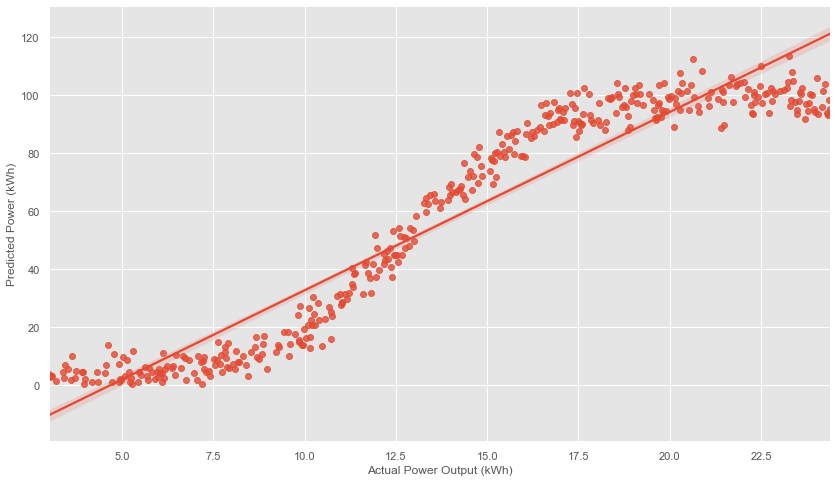

In [19]:
sns.regplot(x=x, y=y)
plt.xlabel('Actual Power Output (kWh)')
plt.ylabel('Predicted Power (kWh)')

In [20]:
# Adapted from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/models.ipynb 
def f(x, p):
    return p[0] + x * p[1]

In [21]:
f(20, p)

94.17203218164212

#### Conclusion

Regression is a process where a model learns to predict a continuous value output for a given input data, Linear regression model does not fit the dataset as it does not flex with subtleties in the relationship between the variables. Linear regression is not very flexible and not very accurate due to its rigidity. The model does not capture underlying trends in the relationship between wind power and speed. 

***

### Polynomial Regression
The search for a more flexible and therefore more accurate model for this dataset needs to move to models that are more interpretative.  Polynomial regression is another form of regression in which the maximum power of the independent variable is more than 1. In this regression technique, the best fit line is not a straight line instead it is in the form of a curve.

Quadratic regression, or regression with second order polynomial, is given by the following equation:

$$Y =Θ1 +Θ2*x +Θ3*x2$$
On initial review, polynomial regression would appear to fit the data better than linear regression as it flexes with data that is above or below the line. 

In [22]:
# Assign features and labels to the working data set
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

#### Train the Model

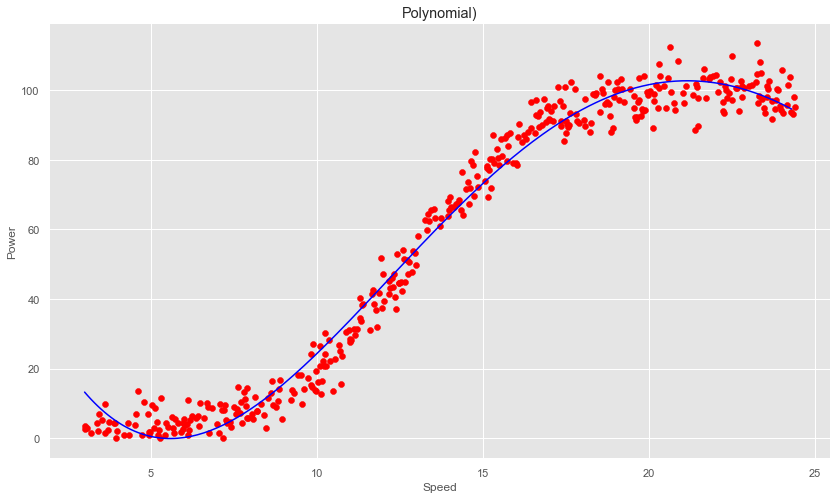

In [23]:
# Import libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Train the model 
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x)
lin_reg = LinearRegression()
lin_reg.fit(x_poly,y)
 
x_grid = np.arange(min(x),max(x),0.1)
x_grid = x_grid.reshape(len(x_grid),1) 
plt.scatter(x,y, color='red') 
 
plt.plot(x_grid, lin_reg.predict(poly_reg.fit_transform(x_grid)),color='blue') 
 
plt.title("Polynomial)")
plt.xlabel('Speed')
plt.ylabel('Power')
plt.show()

#### Predict

In [24]:
y_pr = lin_reg.predict(poly_reg.fit_transform([[20]]))
y_pr

array([[101.62480141]])

#### Conclusion

Polynomial is better fit for the power production data set as it adapts to the nuances in the relationship between wind speed and power.  Polynomial regression is flexible and more accurate than simple linear regression due to its flexibility. The model captures underlying trends in the relationship between wind power and speed.

***

### Random Forest

Random Forest is another interpretative algorithm that would appear to suit the power production data set.
It is a model made up of decision trees using random sampling of training data points when building trees and random subsets of features when splitting nodes.

When training, each tree in a random forest learns from a random sample of the data points. The samples are drawn with replacement,  which means that some samples will be used multiple times in a single tree. By training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

At test time, predictions are made by averaging the predictions of each decision tree. 

In the algorithm, a decision tree is built by determining the splits of nodes that lead to the greatest reduction in Gini Impurity. The decision tree try to form nodes containing a high proportion of samples (data points) from a single class by finding values in the features that cleanly divide the data into classes.[13]

#### Train the Model

In [25]:
# Assign features and labels to the working data set
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

# Adapted from https://www.askpython.com/python/examples/random-forest-regression

# for 50 trees
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50, random_state = 2)
regressor.fit(x,y) 

RandomForestRegressor(n_estimators=50, random_state=2)

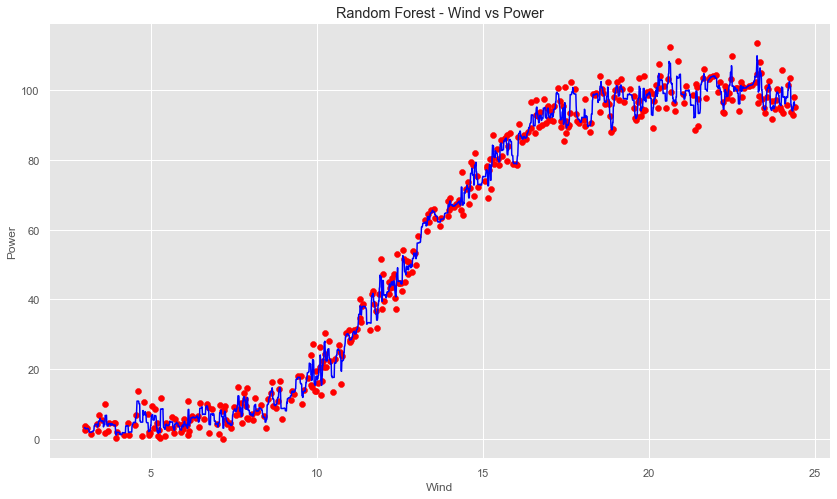

In [26]:
# Adapted from https://www.askpython.com/python/examples/random-forest-regression
x_grid = np.arange(min(x),max(x),0.01)
x_grid = x_grid.reshape(len(x_grid),1) 
  
plt.scatter(x,y, color='red') #plotting real points
plt.plot(x_grid, regressor.predict(x_grid),color='blue') #plotting for predict points
  
plt.title("Random Forest - Wind vs Power")
plt.xlabel('Wind')
plt.ylabel('Power')
plt.show()

#### Predict

In [27]:
y_pred=regressor.predict([[20]])
y_pred

array([99.03046])

#### Conclusion

Random Forest is a flexible and intuitive model which results in accurate predictions. The final predictions of the random forest are made by averaging the predictions of each individual tree. Every prediction is based on 50 votes (50 decision trees in the code). Random forest calculates many averages for each of these intervals.  This is an impressive algorithm and flexes to provide the best result.  The greater the number of trees, the more accurate is the result. The next step is to see if neural networks can out perform the models reviewed thus far.

***

### Keras Neural network

#### Create Keras Model

Keras uses the efficient numerical computation TensorFlow allowing definition and training of neural network models. Models in Keras are defined as a sequence of layers.  A sequential model is created with layers added until the network architecture is working properly. The input layer needs the right number of input features which can be specified when creating the first layer.  Fully connected layers are defined using the Dense class. The number of neurons or nodes in the layer is specified as is the activation function using the activation argument. [15]

In [28]:
# Import tensorflow.
import tensorflow.keras as kr

In [29]:
# Adapted from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb
# Create a new neural network.
m = kr.models.Sequential()

# Add multiple layers, initialised with weight and bias.
m.add(kr.layers.Dense(66, input_dim=1, activation="relu",kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
m.add(kr.layers.Dense(32, activation='sigmoid'))
m.add(kr.layers.Dense(16, activation='sigmoid'))
m.add(kr.layers.Dense(1, activation=None))

#### Compile Model

During compilation, the model automatically chooses the best way to represent the network for training and making predictions. Training a network means finding the best set of weights to map inputs to outputs.  The loss function is specified to evaluate a set of weights, the optimizer is used to search through different weights for the network and any optional metrics we would like to collect and report during training.

The Mean Squared Error (MSE), loss is the default loss to use for regression problems.

The optimizer as the efficient stochastic gradient descent algorithm “adam“. This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems. [15]

In [30]:
# Compile the model.
m.compile(loss="mean_squared_error", optimizer="adam")

#### Fit the model

Training occurs over epochs and each epoch is split into batches.  One epoch is comprised of one or more batches, based on the chosen batch size and the model is fit for many epochs. 

The settings can be chosen experimentally by trial and error. The model will always have some error, but the amount of error will level out after some point for a given model configuration. This is called model convergence.

In [31]:
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

In [32]:
# fit the keras model on the dataset
m.fit(x, y, epochs=500, batch_size=12)
m.summary()

Epoch 1/500
35/35 [==============================] - 1s 1ms/step - loss: 4957.5688
Epoch 2/500
35/35 [==============================] - 0s 1ms/step - loss: 4605.0219
Epoch 3/500
35/35 [==============================] - 0s 1ms/step - loss: 4174.0690
Epoch 4/500
35/35 [==============================] - 0s 941us/step - loss: 4513.5283
Epoch 5/500
35/35 [==============================] - 0s 1ms/step - loss: 4255.4792
Epoch 6/500
35/35 [==============================] - 0s 971us/step - loss: 4400.9332
Epoch 7/500
35/35 [==============================] - 0s 1ms/step - loss: 4125.4882
Epoch 8/500
35/35 [==============================] - 0s 1ms/step - loss: 4127.2753
Epoch 9/500
35/35 [==============================] - 0s 941us/step - loss: 4081.3052
Epoch 10/500
35/35 [==============================] - 0s 2ms/step - loss: 4213.1178
Epoch 11/500
35/35 [==============================] - 0s 1ms/step - loss: 3932.1307
Epoch 12/500
35/35 [==============================] - 0s 1ms/step - loss: 4124.

35/35 [==============================] - 0s 1ms/step - loss: 1487.0332
Epoch 98/500
35/35 [==============================] - 0s 941us/step - loss: 1362.7839
Epoch 99/500
35/35 [==============================] - 0s 912us/step - loss: 1440.5447
Epoch 100/500
35/35 [==============================] - 0s 928us/step - loss: 1477.3497
Epoch 101/500
35/35 [==============================] - 0s 882us/step - loss: 1345.6224
Epoch 102/500
35/35 [==============================] - 0s 882us/step - loss: 1255.0821
Epoch 103/500
35/35 [==============================] - 0s 972us/step - loss: 1370.6614
Epoch 104/500
35/35 [==============================] - 0s 912us/step - loss: 1410.2786
Epoch 105/500
35/35 [==============================] - 0s 882us/step - loss: 1288.9018
Epoch 106/500
35/35 [==============================] - 0s 941us/step - loss: 1303.9722
Epoch 107/500
35/35 [==============================] - 0s 942us/step - loss: 1136.6943
Epoch 108/500
35/35 [==============================] - 0s 941

35/35 [==============================] - 0s 912us/step - loss: 256.3954
Epoch 193/500
35/35 [==============================] - 0s 942us/step - loss: 260.9037
Epoch 194/500
35/35 [==============================] - 0s 941us/step - loss: 247.1990
Epoch 195/500
35/35 [==============================] - 0s 911us/step - loss: 262.6953
Epoch 196/500
35/35 [==============================] - 0s 911us/step - loss: 271.7574
Epoch 197/500
35/35 [==============================] - 0s 854us/step - loss: 237.2238
Epoch 198/500
35/35 [==============================] - 0s 913us/step - loss: 224.2967
Epoch 199/500
35/35 [==============================] - 0s 854us/step - loss: 248.6331
Epoch 200/500
35/35 [==============================] - 0s 824us/step - loss: 250.0571
Epoch 201/500
35/35 [==============================] - 0s 853us/step - loss: 224.6119
Epoch 202/500
35/35 [==============================] - 0s 941us/step - loss: 220.0069
Epoch 203/500
35/35 [==============================] - 0s 912us/step

35/35 [==============================] - 0s 883us/step - loss: 23.2501
Epoch 289/500
35/35 [==============================] - 0s 911us/step - loss: 22.9670
Epoch 290/500
35/35 [==============================] - 0s 882us/step - loss: 28.4511
Epoch 291/500
35/35 [==============================] - 0s 882us/step - loss: 23.9127
Epoch 292/500
35/35 [==============================] - 0s 853us/step - loss: 22.8441
Epoch 293/500
35/35 [==============================] - 0s 941us/step - loss: 27.2424
Epoch 294/500
35/35 [==============================] - 0s 889us/step - loss: 22.1984
Epoch 295/500
35/35 [==============================] - 0s 854us/step - loss: 24.9367
Epoch 296/500
35/35 [==============================] - 0s 882us/step - loss: 22.6294
Epoch 297/500
35/35 [==============================] - 0s 854us/step - loss: 22.2158
Epoch 298/500
35/35 [==============================] - 0s 825us/step - loss: 28.1661
Epoch 299/500
35/35 [==============================] - 0s 853us/step - loss: 26

Epoch 385/500
35/35 [==============================] - 0s 853us/step - loss: 18.7717
Epoch 386/500
35/35 [==============================] - 0s 853us/step - loss: 20.1029
Epoch 387/500
35/35 [==============================] - 0s 824us/step - loss: 18.4947
Epoch 388/500
35/35 [==============================] - 0s 853us/step - loss: 18.0750
Epoch 389/500
35/35 [==============================] - 0s 913us/step - loss: 17.7691
Epoch 390/500
35/35 [==============================] - 0s 912us/step - loss: 19.5808
Epoch 391/500
35/35 [==============================] - 0s 942us/step - loss: 18.7247
Epoch 392/500
35/35 [==============================] - 0s 883us/step - loss: 18.2986
Epoch 393/500
35/35 [==============================] - 0s 853us/step - loss: 17.5628
Epoch 394/500
35/35 [==============================] - 0s 853us/step - loss: 18.0467
Epoch 395/500
35/35 [==============================] - 0s 854us/step - loss: 21.1864
Epoch 396/500
35/35 [==============================] - 0s 853us/s

35/35 [==============================] - 0s 1ms/step - loss: 19.2344
Epoch 483/500
35/35 [==============================] - 0s 1ms/step - loss: 19.0965
Epoch 484/500
35/35 [==============================] - 0s 1ms/step - loss: 19.1539
Epoch 485/500
35/35 [==============================] - 0s 971us/step - loss: 18.0147
Epoch 486/500
35/35 [==============================] - 0s 971us/step - loss: 17.0085
Epoch 487/500
35/35 [==============================] - 0s 941us/step - loss: 17.3072
Epoch 488/500
35/35 [==============================] - 0s 971us/step - loss: 19.8736
Epoch 489/500
35/35 [==============================] - 0s 971us/step - loss: 16.2594
Epoch 490/500
35/35 [==============================] - 0s 971us/step - loss: 20.2973
Epoch 491/500
35/35 [==============================] - 0s 1ms/step - loss: 17.1113
Epoch 492/500
35/35 [==============================] - 0s 1000us/step - loss: 19.5333
Epoch 493/500
35/35 [==============================] - 0s 971us/step - loss: 19.2072
E

#### Evaluate 
The neural network has been trained on the entire dataset and performance is evaluated on that same dataset.  This will  give an indication of how well the dataset has been modelled.

In [33]:
scores = m.evaluate(x, y, verbose=0)
print(scores)
# print("%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

21.509899139404297


#### Predict

In [34]:
result = m.predict([20])
#type(result[0])
#result = np.ndarray.item(result[0])
result

array([[98.620255]], dtype=float32)

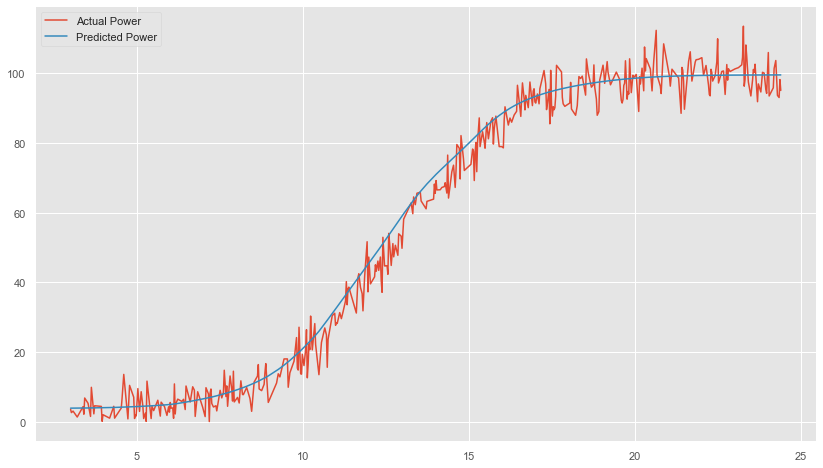

In [35]:
# Plot Data and Predictions to Visualise
plt.plot(x, y, label='Actual Power')
plt.plot(x, m.predict(x), label='Predicted Power')
plt.legend()

#### Conclusion


The general goal of machine learning is to build models that can learn from data without being explicitly programmed.
Keras achieve impressively - it creates a sequential model and layers are added to the model until the network architecture produces acceptable results. There is some trial and error involved.  However it is very flexible and appears very accurate.

### Determine Model 

Choosing an appropriate model depends on a number of factors:

- The dataset is small - all the models would be able to cope with the dataset.

- The distribution of the data -  data is uniformly distributed therefore the models can deal with the variables.

- The relationship between the variables.  Linear Regression is ruled out as it assumes a clear linear relationship which is not the case.  I will attempt to create the power predictor on all the models in order to compare results.

***

## Conclusion

The dataset did need to be cleaned as wind turbines produce electricity approximately 85% of the time. The other 15% of the time they are not turning for reasons, such as low wind speeds very high wind speeds, and maintenance/repair work.[1]  4 models have been built in this notebook that can predict the power output based on wind speed.  Linear Regression is very basic, however random forest, polynomial and Neural networks perform very well.  


***

## References
[1] https://www.hindawi.com/journals/jen/2016/8519785/<br>
[2] https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb <br>
[3] https://keras.io/getting_started/intro_to_keras_for_engineers <br>
[4] https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf <br>
[5] https://blogs.oracle.com/datascience/supervised-learning-with-python<br>
[6] https://scikit-learn.org/stable/index.html <br>
[7] https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb<br>
[8] https://www.esb.ie/tns/education-hub/future-energy/wind-energy<br>
[9] http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf Deep Learning with Python by Francois Chollet <br>
[10] https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior <br>
[11] https://www.askpython.com/python/examples/random-forest-regression<br>
[12] https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/<br>
[13] https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76<br>
[14] https://keras.io/guides/writing_a_training_loop_from_scratch<br>
[15] https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/<br>

### The End